In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor

from transformers import AmountCentsOnly, Log1pAmount, TimeToHour

sns.set(style="ticks")

# Credit Card Fraud
https://www.kaggle.com/mlg-ulb/creditcardfraud

## Features
---------------
- __Time:__ seconds elapsed fromfirst transaction in dataset
- __V1-V28:__ PCA components
- __Class:__ 1 fraud / 0 otherwise
- __Amount:__ transaction amount

In [2]:
data_dir = Path.cwd() / 'data'
pkl_dir = data_dir / 'pkl'

credit = pd.read_pickle(pkl_dir / 'credit_train.pkl')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,12.95,0
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,25.57,0
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,6.90,0
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,4.55,0
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,3.79,0


No need to clean the values of the data. There are no null values, and the data types are already numeric.

In [3]:
print(f"Data types: {np.unique(credit.dtypes)}")
print(f"Null values: {credit.isna().sum().sum()}")

Data types: [dtype('int64') dtype('float64')]
Null values: 0


In [4]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94832.242876,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,...,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,47500.701858,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,...,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,0.000000,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54202.000000,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,...,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,84737.000000,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,...,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,139337.000000,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,...,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


## Class Imbalance
------------------------

In [5]:
classes, counts = np.unique(credit['Class'], return_counts=True)

maj_cls_size = counts.max()
min_cls_size = counts.min()

maj_cls_label = classes[counts == maj_cls_size].item()
min_cls_label = classes[counts == min_cls_size].item()

cls_ratio = min_cls_size / maj_cls_size

print(f"{min_cls_size} minority class samples")
print(f"{maj_cls_size} majority class samples")
print(f"{cls_ratio:.5%} class imbalance")

391 minority class samples
227454 majority class samples
0.17190% class imbalance


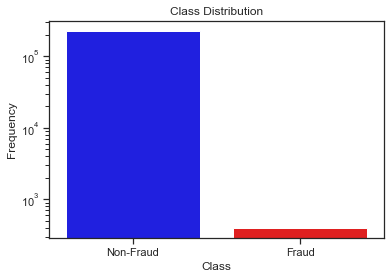

In [6]:
counts = credit['Class'].value_counts()
labels = ['Non-Fraud', 'Fraud']
ax = sns.barplot(x=labels, y=counts, log=True, palette=['blue', 'red'])
ax.set(xlabel='Class', ylabel='Frequency', title='Class Distribution');

## Time
----------

Observe that there are two days worth of data.

In [7]:
max_seconds = credit['Time'].max()
max_seconds

172792.0

In [8]:
day_seconds = 24 * 60 * 60

predicate = lambda x: x - day_seconds <= max_seconds
iterable = (day_seconds * i for i in itertools.count())
tuple(itertools.takewhile(predicate, iterable))

(0, 86400, 172800)

When graphed, we can clearly see a two day cycle of how many transactions are undergone during the day. I'll assume that the peaks are during daytime and the valleys are at night.

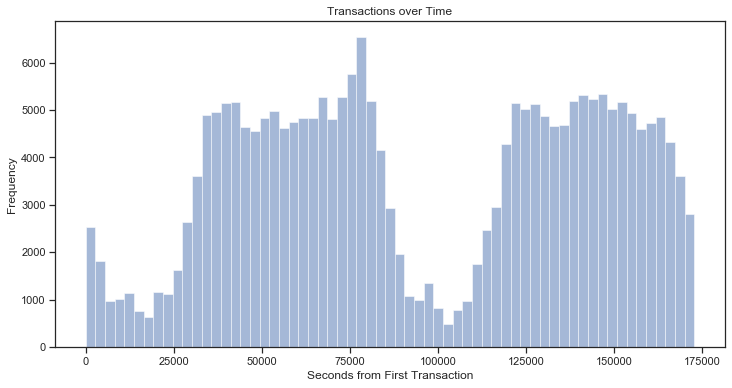

In [9]:
bins = len(np.histogram_bin_edges(credit['Time'], bins='auto'))

plt.figure(figsize=(12, 6))
plt.hist(credit['Time'], bins=bins, alpha=0.5)
plt.title('Transactions over Time')
plt.xlabel('Seconds from First Transaction')
plt.ylabel('Frequency');

Let's regularize this to have a column for the hour of the day rather than time from the first transaction. Assume midnight occurs at the minimums.

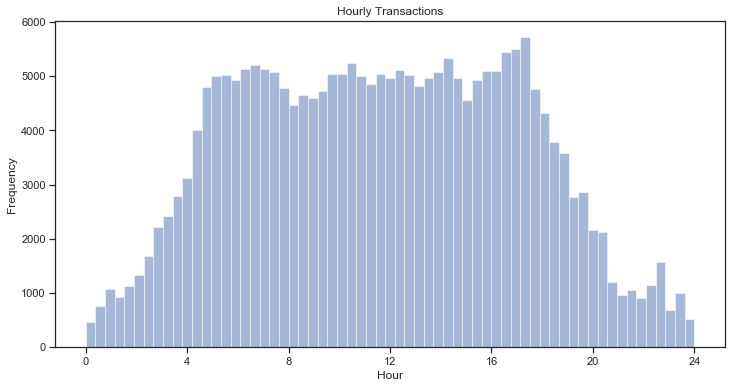

In [10]:
credit = TimeToHour().fit_transform(credit)

plt.figure(figsize=(12, 6))
plt.hist(credit['Hour'], bins=bins, alpha=0.5)
plt.title('Hourly Transactions')
plt.xticks(range(0, 25, 4))
plt.xlabel('Hour')
plt.ylabel('Frequency');

## Non-Fraud vs Fraud
-----------------------------

In [11]:
is_fraud = credit['Class'] == min_cls_label

nonfraud = credit[~is_fraud]
fraud = credit[is_fraud]

nf_desc = nonfraud.describe()['Amount']
nf_desc.name = 'Not Fraud'

fr_desc = fraud.describe()['Amount']
fr_desc.name = 'Fraud'

pd.concat([nf_desc, fr_desc], axis=1)

,Not Fraud,Fraud
count,227454.000000,391.000000
mean,88.566586,125.638107
std,248.005952,263.658004
min,0.000000,0.000000
25%,5.740000,1.000000
50%,22.000000,14.460000
75%,77.500000,106.270000
max,19656.530000,2125.870000


### Cent Distribution

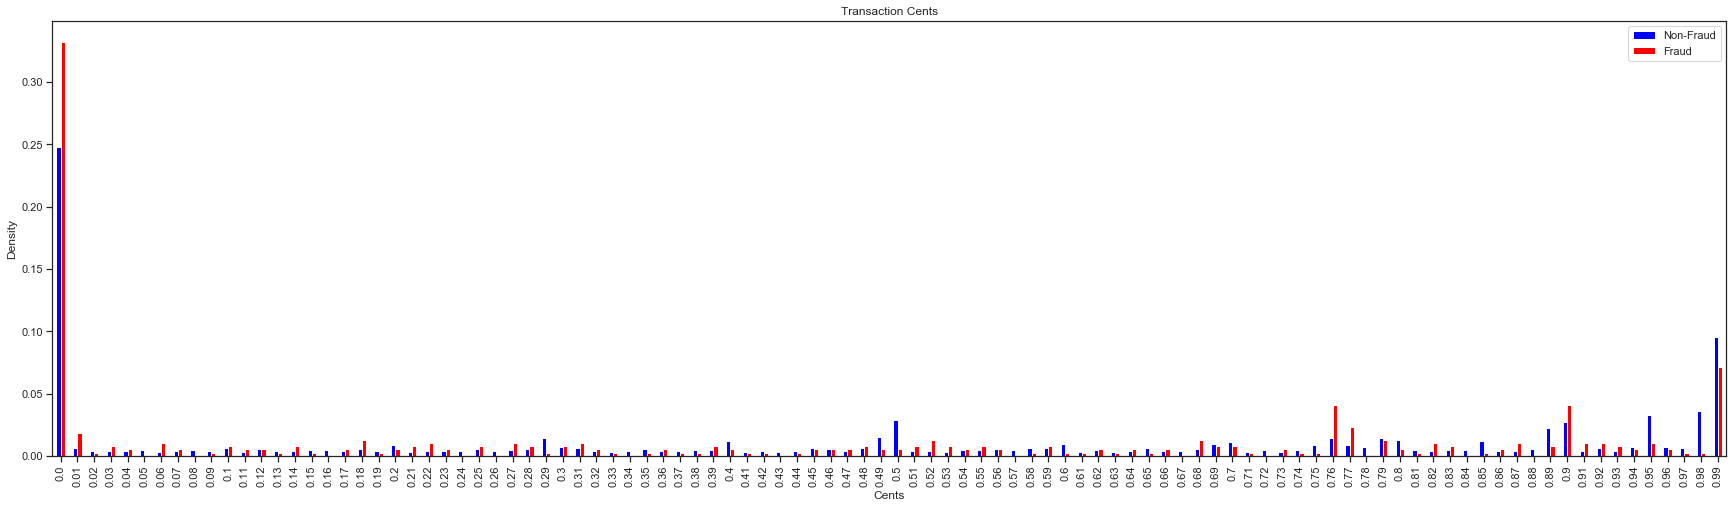

In [12]:
credit = AmountCentsOnly().fit_transform(credit)
cents = credit['Cents']
all_cents_vc = cents.value_counts()

nonfraud_cents_vc = cents[~is_fraud].value_counts()
nonfraud_cents_norm = (nonfraud_cents_vc / nonfraud_cents_vc.sum()).sort_index()

fraud_cents_vc = cents[is_fraud].value_counts()
fraud_cents_norm = (fraud_cents_vc / fraud_cents_vc.sum()).sort_index()

cents_norm = pd.concat([nonfraud_cents_norm, fraud_cents_norm], axis=1)
cents_norm.columns = ['Non-Fraud', 'Fraud']

cents_norm.plot.bar(figsize=(30, 8), color=['blue', 'red'], title='Transaction Cents')
plt.xlabel('Cents')
plt.ylabel('Density');

In [13]:
cents_ratio = cents_norm['Non-Fraud'] / cents_norm['Fraud']
cents_ratio[cents_ratio >= 3]

0.29     5.471669
0.50     5.551604
0.60     3.747483
0.75     3.451810
0.85     4.656849
0.95     3.180203
0.98    13.918977
dtype: float64

Non-fraud transactions are more than 3x as likely to have 0.29, 0.50, 0.60, 0.75, 0.85, 0.95, and 0.98 cents in the amount spent.  
Of significant notice is that 0.98 cents is nearly 14x as common with non-fradulent amounts.

In [14]:
cents_ratio[cents_ratio <= 1/3]

0.01    0.332509
0.52    0.324209
dtype: float64

Fraud transactions are more than 3x as likely to have 0.01 and 0.52 cents in the amount spent.

### Hourly Transactions

#### Scatter Plots

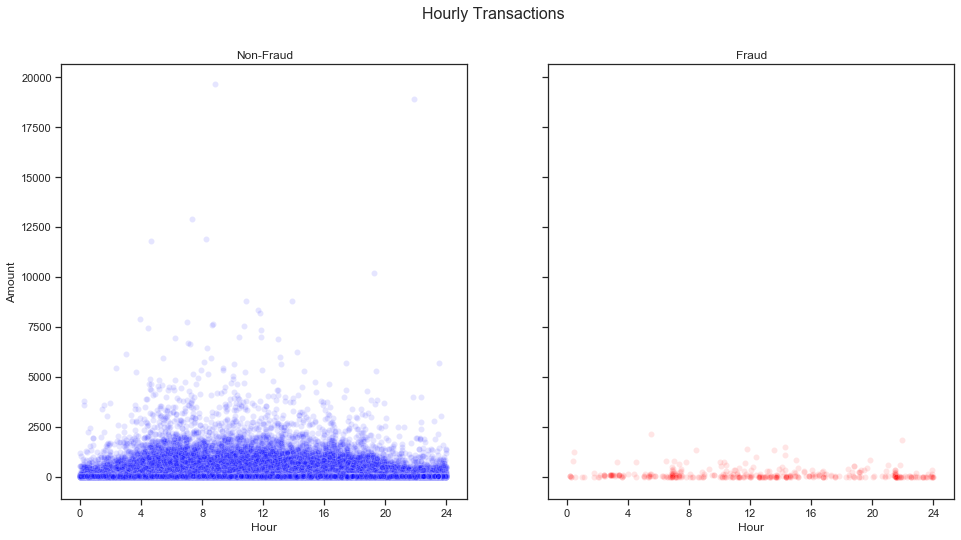

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

fig.suptitle('Hourly Transactions', fontsize=16)

sns.scatterplot(nonfraud['Hour'], nonfraud['Amount'], alpha=0.1, color='blue', ax=ax0)
sns.scatterplot(fraud['Hour'], fraud['Amount'], alpha=0.1, color='red', ax=ax1)

ax0.set_title('Non-Fraud')
ax1.set_title('Fraud')

ax0.set_xticks(range(0, 25, 4))

ax0.set_ylabel('Amount');

It is difficult to see any patterns at this scale, so let's take the Log(Amount + 1) since we want the data to be more vertically spread and don't want undefined logrithm values when Amount = 0.

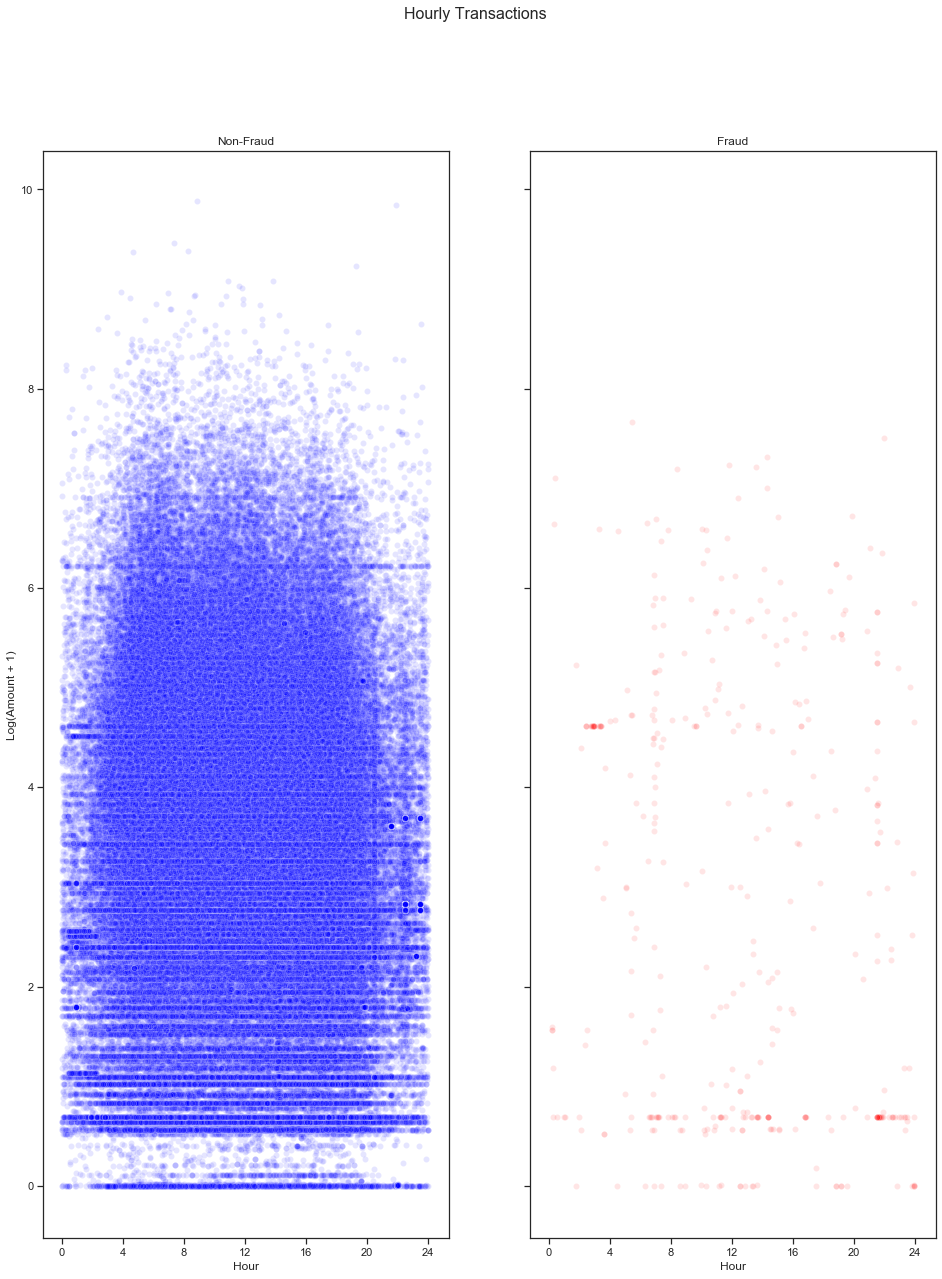

In [16]:
credit = Log1pAmount().fit_transform(credit)
nonfraud = credit[~is_fraud]
fraud = credit[is_fraud]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 20), sharey=True, sharex=True)
fig.suptitle('Hourly Transactions', fontsize=16)

sns.scatterplot(nonfraud['Hour'], nonfraud['Log1pAmount'], alpha=0.1, color='blue', ax=ax0)
sns.scatterplot(fraud['Hour'], fraud['Log1pAmount'], alpha=0.1, color='red', ax=ax1)

ax0.set_title('Non-Fraud')
ax1.set_title('Fraud')

ax0.set_xticks(range(0, 25, 4))

ax0.set_ylabel('Log(Amount + 1)');

From this we can see horizontal bands which are indicative of people spending "benchmark" amounts of money. For example, a transaction is more likely to be 100 dollars than 105.67 dollars.

#### Box and Violin Plots

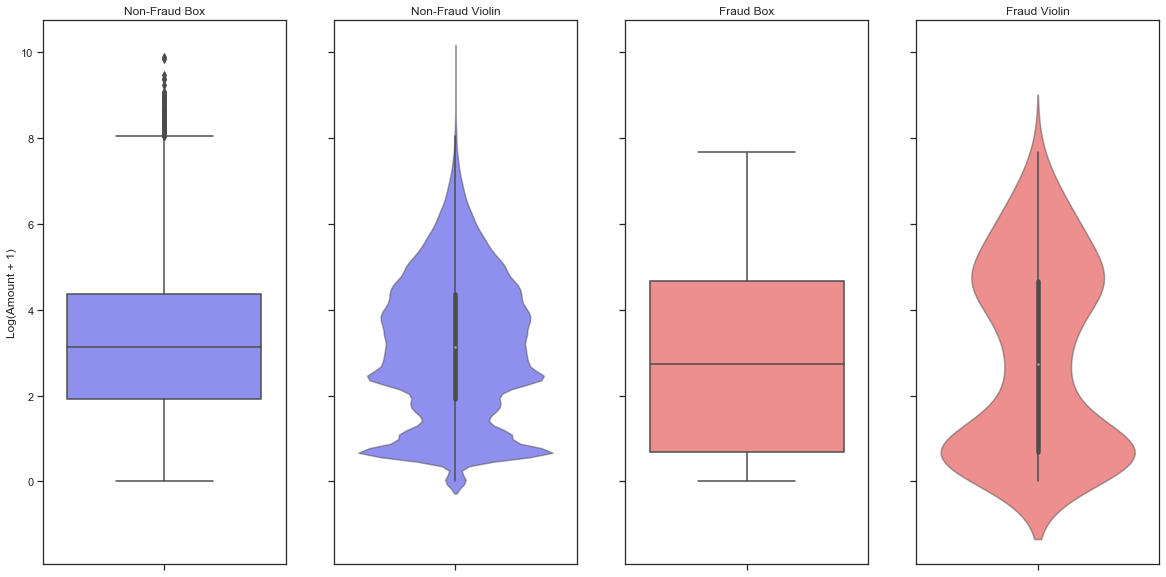

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
ax0, ax1, ax2, ax3 = axes

sns.violinplot(nonfraud['Log1pAmount'], orient='v', color='blue', ax=ax1)
sns.violinplot(fraud['Log1pAmount'], orient='v', color='red', ax=ax3)

sns.boxplot(nonfraud['Log1pAmount'], orient='v', color='blue', ax=ax0)
sns.boxplot(fraud['Log1pAmount'], orient='v', color='red', ax=ax2)

alpha = 0.5
for ax in axes:
    plt.setp(ax.collections, alpha=alpha)  # voilin

    for patch in ax.artists:  # box
        r, g, b, _ = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))
        
ax0.set_ylabel('Log(Amount + 1)')
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax3.set_ylabel(None)

ax0.set_title('Non-Fraud Box')
ax1.set_title('Non-Fraud Violin')
ax2.set_title('Fraud Box')
ax3.set_title('Fraud Violin');

From the boxplots, we can see that the whiskers are basically identical between the two classes. The non-fraud has visible outliers according to boxplot standards. The interquartile range of fraud is wider, but that could be a result of a much smaller sample size. Also we can see that the average transaction for fraud is lower than non-fraud activity.

Regarding the violinplots, they have roughly the same shape with a top and bottom, but the non-fraud is less smooth.

#### Hexbin Plot

In [18]:
def hex_plot(df1, df2, t1, t2, c1='Blues', c2='Reds'):
    x, y = 'Hour', 'Log1pAmount'
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7), sharey=True, sharex=True)
    
    fig.suptitle('Hourly Transactions', fontsize=16)

    ax0.hexbin(df1[x], df1[y], gridsize=10, cmap=c1)
    ax1.hexbin(df2[x], df2[y], gridsize=10, cmap=c2)
    
    ax0.set_title(t1)
    ax1.set_title(t2)
    
    ax0.set_xlabel(x)
    ax1.set_xlabel(x)

    ax0.set_xticks(range(0, 25, 4))
    
    ax0.set_ylabel('Log(Amount + 1)')

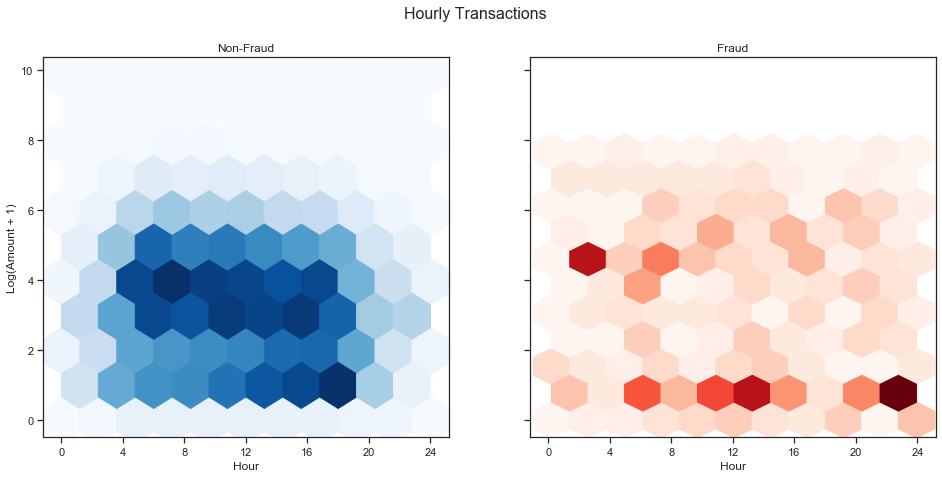

In [19]:
hex_plot(nonfraud, fraud, 'Non-Fraud', 'Fraud')

We can observe that non-fraudulent activity has a smaller density of transactions near 0 than fraudulent activity.

#### Line Plot: Average Amounts

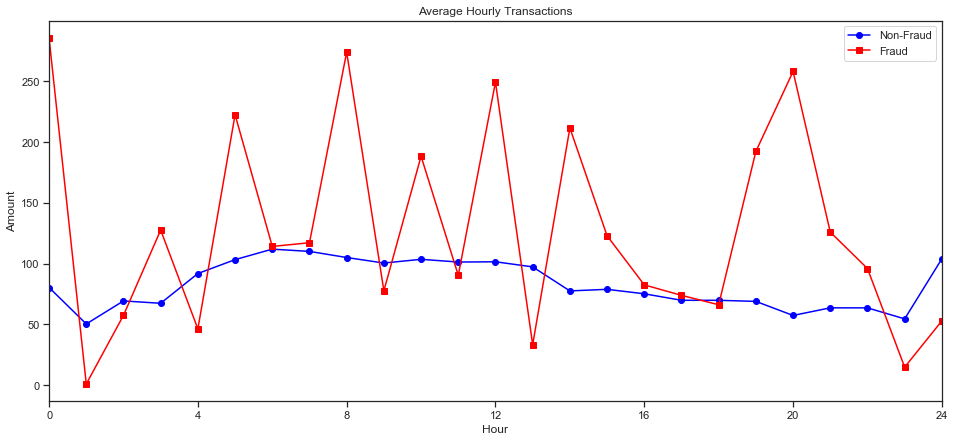

In [20]:
plt.figure(figsize=(16, 7))

(nonfraud.groupby(nonfraud['Hour'].round())['Amount'].mean()
         .plot(color='blue', marker='o', label='Non-Fraud'))
(fraud.groupby(fraud['Hour'].round())['Amount'].mean()
      .plot(color='red', marker='s', label='Fraud'))

plt.title('Average Hourly Transactions')
plt.legend(['Non-Fraud', 'Fraud'])
plt.xticks(range(0, 25, 4))
plt.ylabel('Amount');

On average, fraudsters make larger transactions.

## Outliers
--------------
Next, we will look for outliers in the data. I conjecture that non-fraud outliers would likely be confused with fraudulent data points.

In [21]:
lof = LocalOutlierFactor(contamination='auto')
nf_preds = lof.fit_predict(nonfraud)

nf_inliers = nonfraud[nf_preds == 1]
nf_in_desc = nf_inliers.describe()['Amount']
nf_in_desc.name = 'NF Inlier'

nf_outliers = nonfraud[nf_preds == -1]
nf_out_desc = nf_outliers.describe()['Amount']
nf_out_desc.name = 'NF Outlier'

pd.concat([nf_desc, nf_in_desc, nf_out_desc], axis=1)

,Not Fraud,NF Inlier,NF Outlier
count,227454.000000,223674.000000,3780.000000
mean,88.566586,81.228662,522.773643
std,248.005952,191.946783,1153.055529
min,0.000000,0.000000,0.000000
25%,5.740000,5.490000,46.057500
50%,22.000000,21.200000,147.545000
75%,77.500000,74.990000,396.825000
max,19656.530000,5114.100000,19656.530000


In [22]:
lof = LocalOutlierFactor(contamination='auto')
fr_preds = lof.fit_predict(fraud)

fr_inliers = fraud[fr_preds == 1]
fr_in_desc = fr_inliers.describe()['Amount']
fr_in_desc.name = 'Fr Inlier'

fr_outliers = fraud[fr_preds == -1]
fr_out_desc = fr_outliers.describe()['Amount']
fr_out_desc.name = 'Fr Outlier'

pd.concat([fr_desc, fr_in_desc, fr_out_desc], axis=1)

,Fraud,Fr Inlier,Fr Outlier
count,391.000000,337.000000,54.000000
mean,125.638107,129.722641,100.147593
std,263.658004,272.072534,203.667702
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,14.460000,17.390000,11.065000
75%,106.270000,108.510000,73.567500
max,2125.870000,2125.870000,802.520000


In [23]:
def display_outliers(df, title, x='Amount', xlabel='Transaction Amount', ax=None):
    lof = LocalOutlierFactor(contamination='auto')
    pred = lof.fit_predict(df)
    
    is_outlier = (pred == -1)
    
    plt.figure(figsize=(20, 10))

    sns.kdeplot(df[~is_outlier][x], label='inliers', linewidth=3, shade=True, ax=ax, color='green')
    sns.kdeplot(df[is_outlier][x], label='outliers', linewidth=3, shade=True, ax=ax, color='purple')

    plt.xlabel(xlabel, fontdict=dict(fontsize=20))
    plt.ylabel('Density', fontdict=dict(fontsize=20))

    plt.legend(prop={'size': 20})
    plt.title(title, fontdict=dict(fontsize=40));

### Fraud Transactions

Fraud outlier and inlier KDE distributions overlap very closely.
- Amount
    - Both have peaks around 0.
    - Outlier has slightly lower peak.
    - Inlier has longer right tail.
- Log(Amount + 1)
    - Overall they are similar other than dip in middle

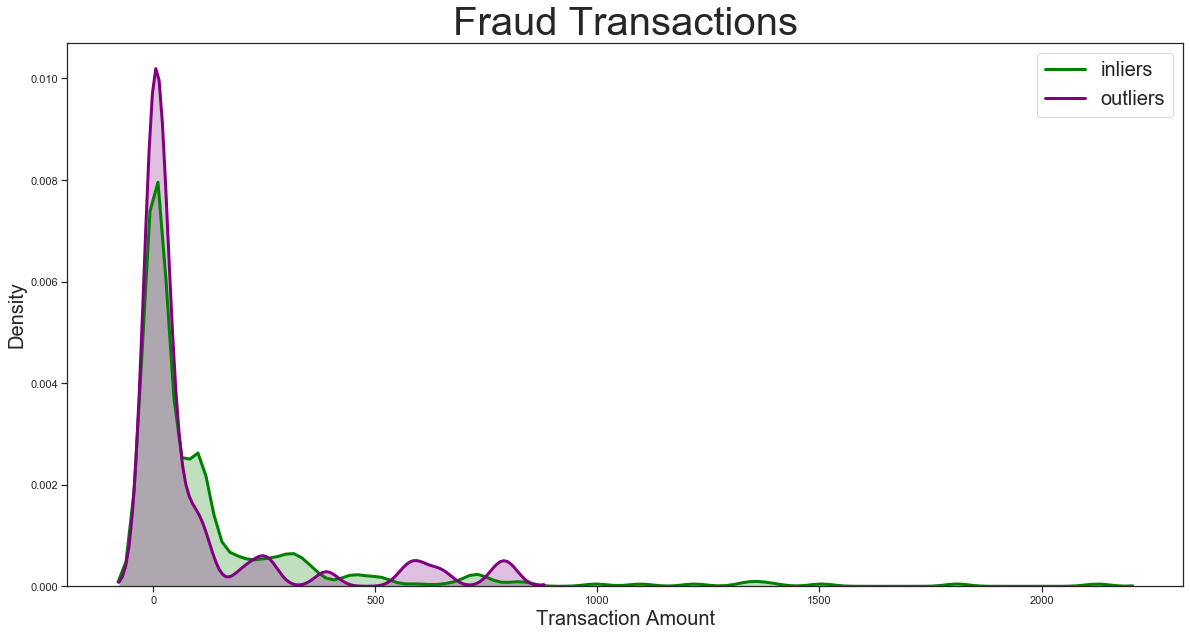

In [24]:
display_outliers(fraud, 'Fraud Transactions', x='Amount', xlabel='Transaction Amount')

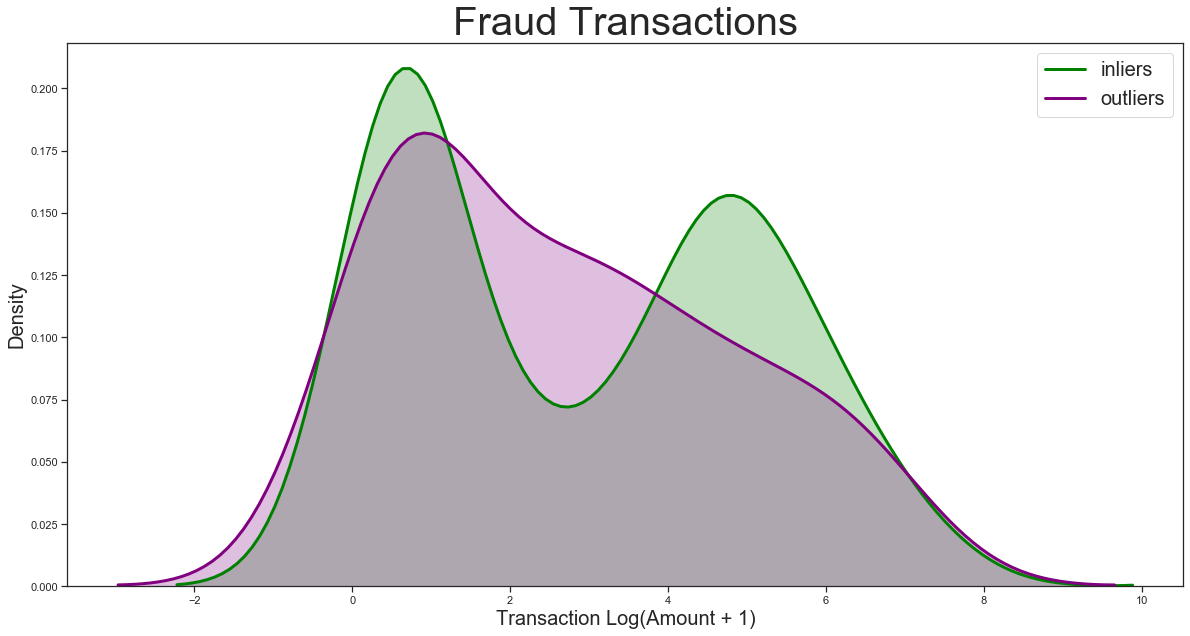

In [25]:
display_outliers(fraud, 'Fraud Transactions', x='Log1pAmount', xlabel='Transaction Log(Amount + 1)')

### Non-Fraud Transactions

Non-fraud outlier and inlier distributions are quite different than the fraud case.
- Amount
    - Outlier peak is not close to 0
    - Inlier peak is half that of the outlier peak.
    - Outlier has a huge right skew.
- Log(Amount + 1)
    - Clear separation of graphs

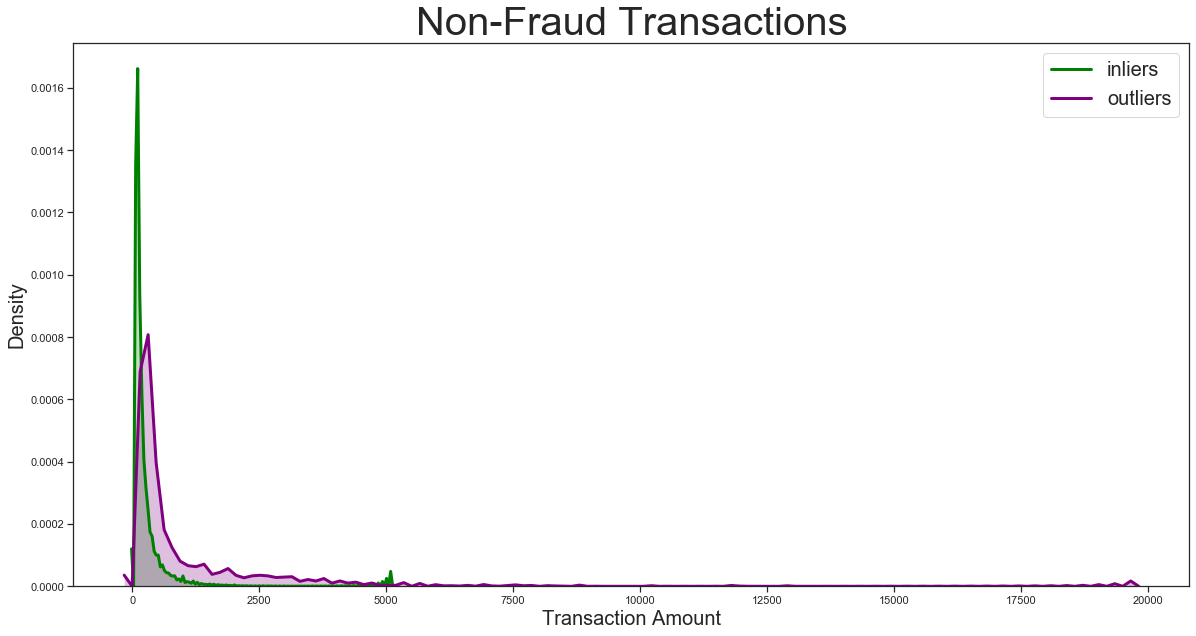

In [26]:
display_outliers(nonfraud, 'Non-Fraud Transactions', x='Amount', xlabel='Transaction Amount')

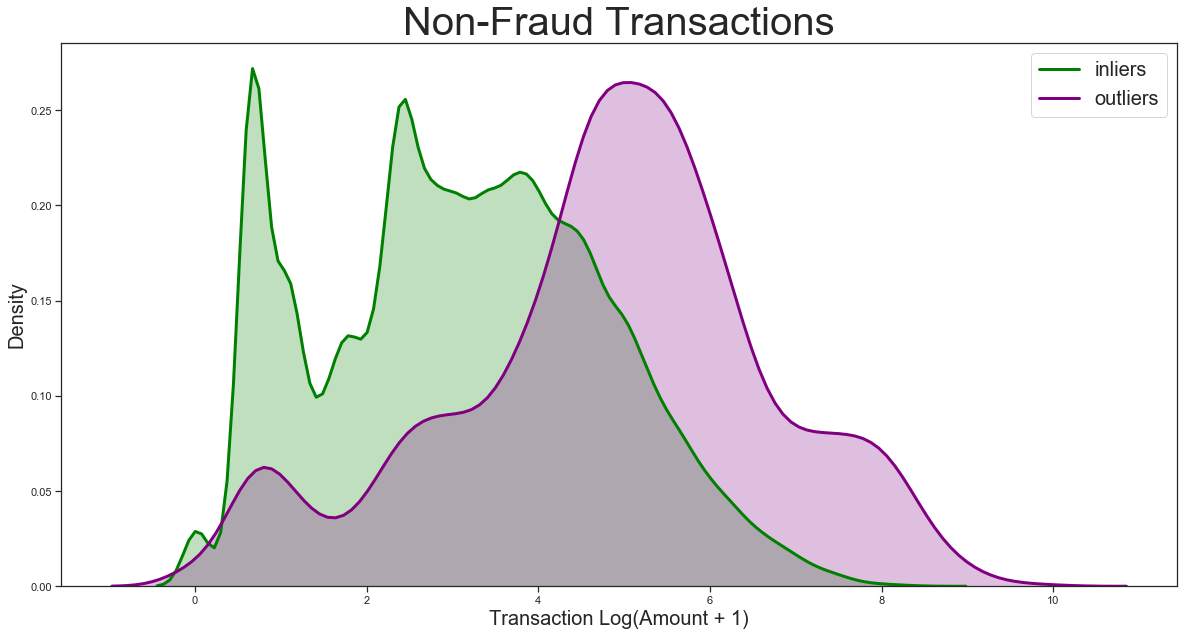

In [27]:
display_outliers(nonfraud, 'Non-Fraud Transactions', x='Log1pAmount', xlabel='Transaction Log(Amount + 1)')

We will experiment later whether removing these non-fraud outliers from the dataset will result int better detection of fraudulent activity. This is acceptable since it only accounts for 1.6% of the dataset.

In [28]:
print(f"Outliers to non-fraud: {len(nf_outliers) / len(nonfraud)}")
print(f"Outliers to all data: {len(nf_outliers) / len(credit)}")

Outliers to non-fraud: 0.016618744889076473
Outliers to all data: 0.016590225811406876


### Inliers vs All

With both the non-fraud and fraud data, their inliers are in alignment with the dataset as a whole.

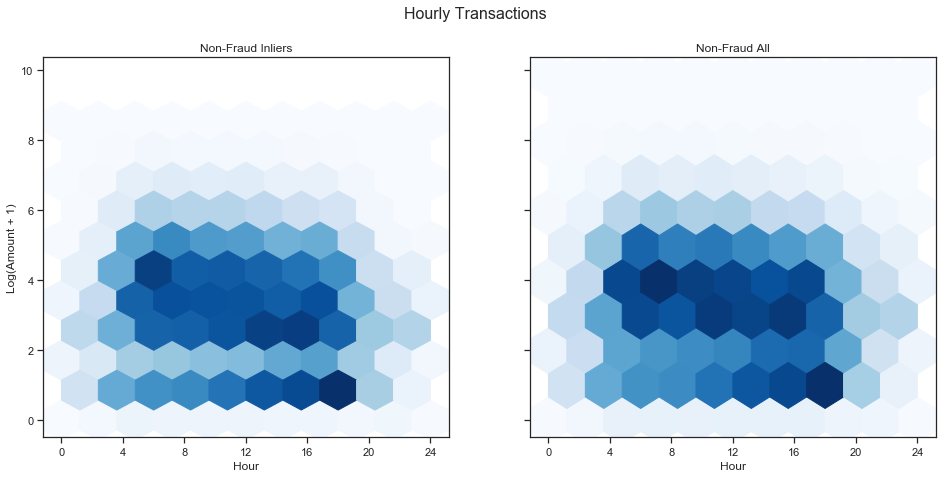

In [29]:
hex_plot(nf_inliers, nonfraud, 'Non-Fraud Inliers', 'Non-Fraud All', c2='Blues')

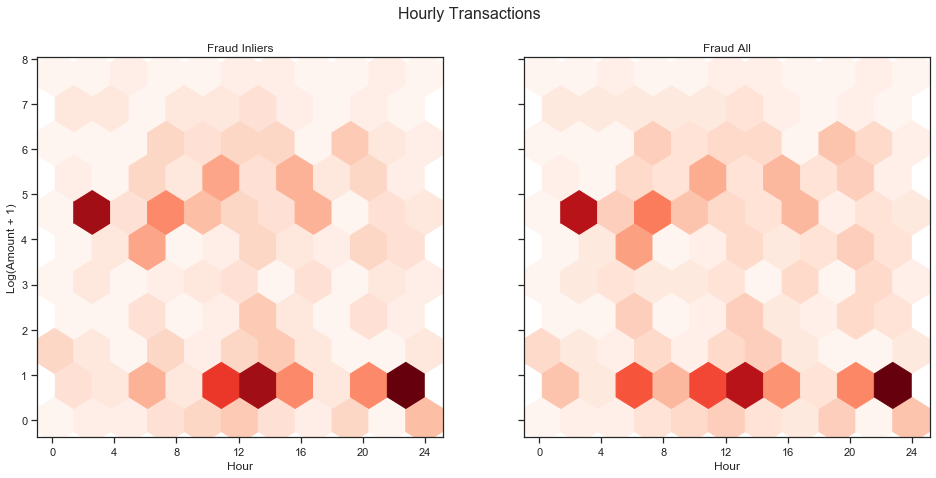

In [30]:
hex_plot(fr_inliers, fraud, 'Fraud Inliers', 'Fraud All', c1='Reds')

## Outliers vs All

Here we get interesting data as the density distributions of transaction amount vs time have drastically different graphs as would be expected.

### Non-Fraud
- Outliers tend to occur at nighttime
- The transaction amount is higher

### Fraud
- Avoiding middle of the day
- Avoiding midnight to early morning

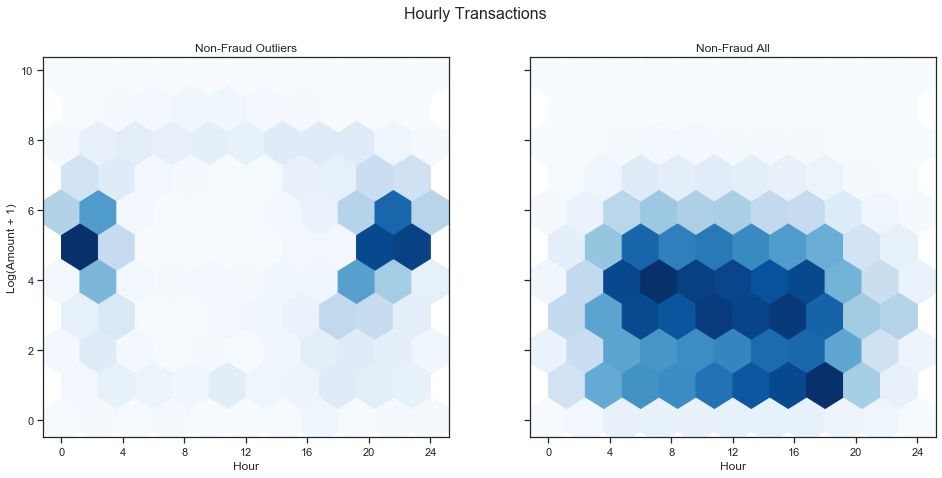

In [31]:
hex_plot(nf_outliers, nonfraud, 'Non-Fraud Outliers', 'Non-Fraud All', c2='Blues')

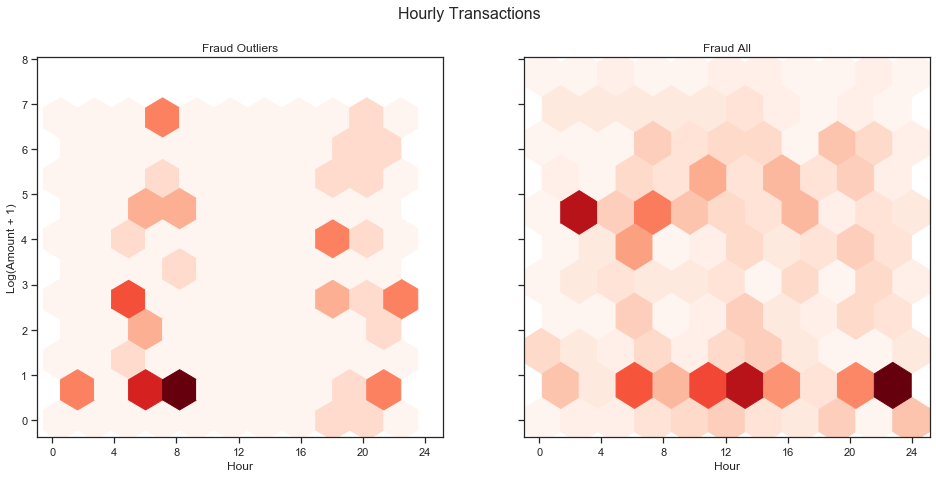

In [32]:
hex_plot(fr_outliers, fraud, 'Fraud Outliers', 'Fraud All', c1='Reds')

#### Heatmap

In [33]:
corr = credit.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Hour,Cents,Log1pAmount
Time,1.000000,0.118718,-0.010865,-0.418937,-0.105459,0.175574,-0.065160,0.086193,-0.036449,-0.010792,...,-0.015788,-0.233723,-0.040991,-0.004813,-0.009510,-0.011231,-0.012819,0.145062,0.014663,-0.028559
V1,0.118718,1.000000,-0.009274,-0.001036,0.001012,0.001537,0.002353,0.007993,0.000061,0.001832,...,0.002916,0.001227,0.002450,0.011317,0.010050,-0.226018,-0.104749,-0.018520,0.000381,-0.095493
V2,-0.010865,-0.009274,1.000000,-0.004270,0.001582,-0.003366,0.002178,-0.002177,-0.005546,0.003833,...,0.001874,0.003736,0.002982,0.011133,0.020296,-0.536808,0.093246,0.070012,0.132859,-0.451192
V3,-0.418937,-0.001036,-0.004270,1.000000,0.002857,-0.003170,0.007196,0.013389,-0.001454,0.001269,...,-0.000773,0.000415,0.001123,0.012218,-0.001333,-0.205139,-0.195210,0.025307,-0.020708,-0.035752
V4,-0.105459,0.001012,0.001582,0.002857,1.000000,0.000585,-0.000769,-0.001973,0.000958,0.000876,...,0.001024,-0.001652,-0.002313,-0.007391,-0.001626,0.098939,0.131397,0.008772,0.038330,-0.005265
V5,0.175574,0.001537,-0.003366,-0.003170,0.000585,1.000000,0.012974,0.030422,-0.003995,-0.001222,...,0.002108,0.000876,0.003076,0.019567,-0.016424,-0.371322,-0.100951,0.007615,0.056510,-0.289754
V6,-0.065160,0.002353,0.002178,0.007196,-0.000769,0.012974,1.000000,-0.019087,-0.000793,0.000108,...,-0.002355,-0.002802,-0.001804,-0.012349,0.011522,0.202164,-0.043344,-0.010621,-0.044203,0.163418
V7,0.086193,0.007993,-0.002177,0.013389,-0.001973,0.030422,-0.019087,1.000000,0.015636,0.004281,...,-0.001977,-0.002675,-0.000922,-0.017925,0.006339,0.378996,-0.193484,-0.008742,0.051994,0.096568
V8,-0.036449,0.000061,-0.005546,-0.001454,0.000958,-0.003995,-0.000793,0.015636,1.000000,0.002927,...,0.002082,0.004018,0.001079,0.008197,-0.001700,-0.095564,0.019554,0.000662,0.016017,-0.019278
V9,-0.010792,0.001832,0.003833,0.001269,0.000876,-0.001222,0.000108,0.004281,0.002927,1.000000,...,-0.000013,0.000118,0.000165,0.003152,-0.003833,-0.045446,-0.096328,0.056449,0.063085,-0.082057


In [34]:
corr[corr != 1].min().min(), corr[corr != 1].max().max()

(-0.5368084159424903, 0.5581798153267568)

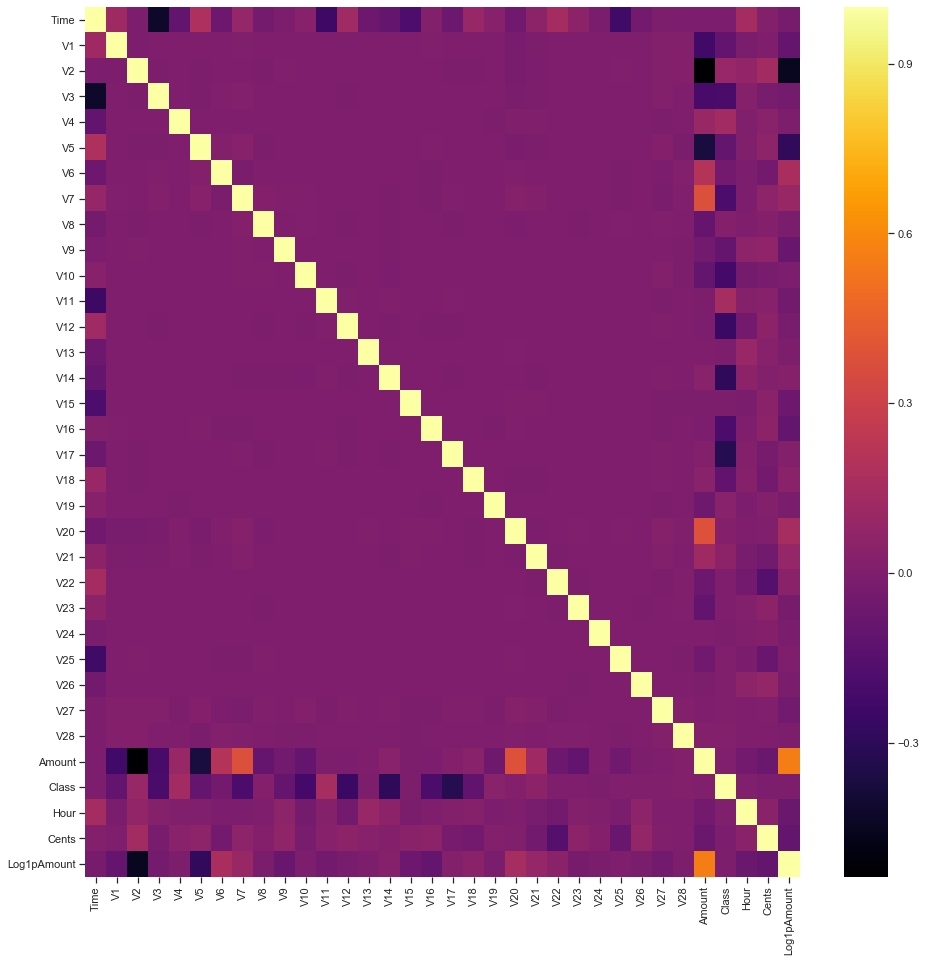

In [35]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, cmap='inferno', ax=ax)

if matplotlib.__version__ == '3.1.1':
    high, low = ax.get_ylim()
    ax.set_ylim(high + 0.5, low - 0.5);

There are no super strong collinearities that we have to worry about. The most extreme cases are -0.536 and 0.558.